In [1]:
# Standard library
import os
import struct
import time
import random
import argparse
import sys

# Third-party library
import numpy as np
from math import e
from typing import List
import math
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F

# Tools
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange

import lightning as L

# Files
sys.path.append(os.path.abspath("../models"))
from res_cnn_64to1024 import VRES_CNN_64to1024
from lightning_caller import Resolution_Recovery

sys.path.append(os.path.abspath("../utils"))
from paired_dataloader import Data
from evaluation import eval_reconstruction, loss_visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET_DIR = "../dataset/raw"

# Input Demo

In [2]:
data_module = Data(
    root_dir=DATASET_DIR,
    brightness=1.0,
    batch_size=32,
    resolution_lr=64,
    resolution_hr=1024
)

data_module.setup()

train_loader  = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [3]:
lr_batch, hr_batch = next(iter(data_module.train_dataloader()))
print(lr_batch.shape, hr_batch.shape)

torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 1024, 1024])


[rank: 0] Seed set to 42


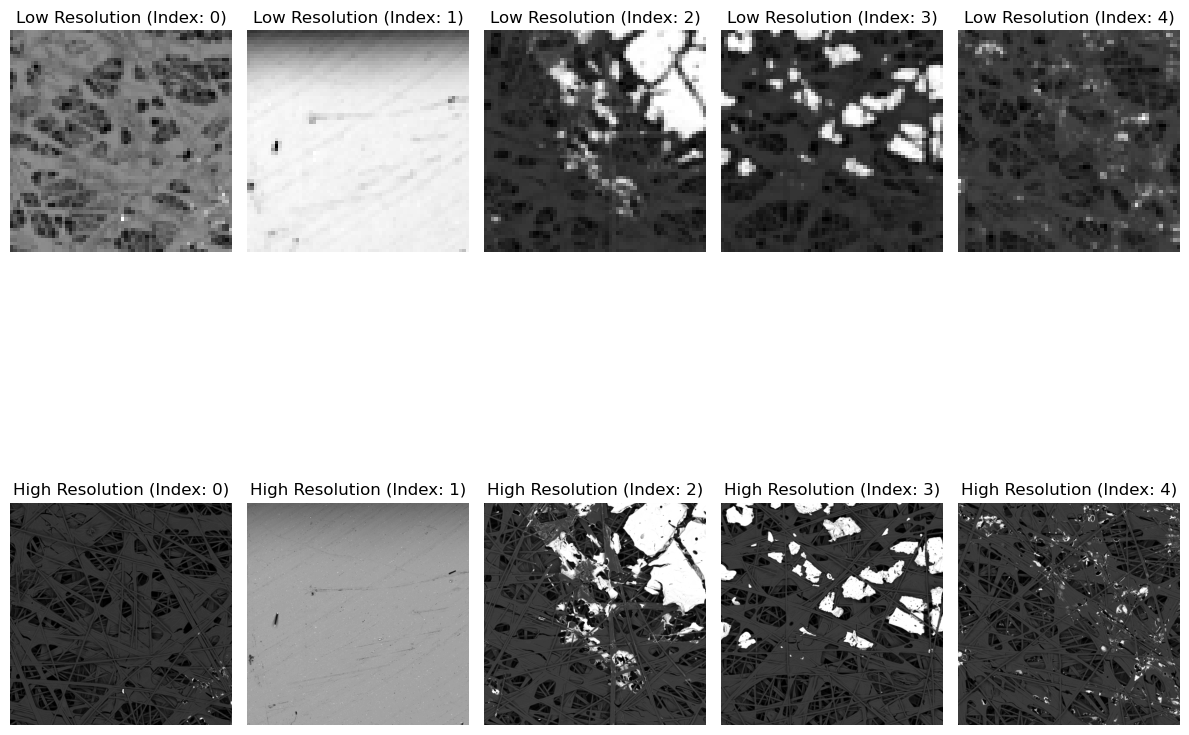

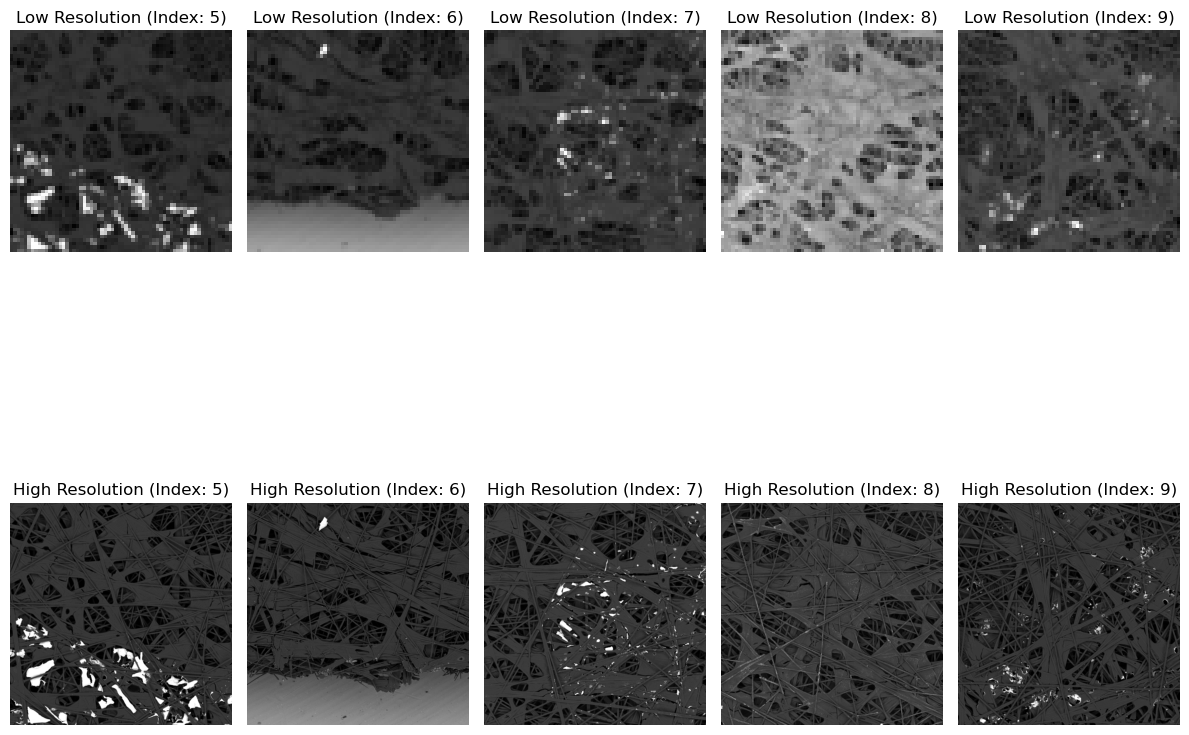

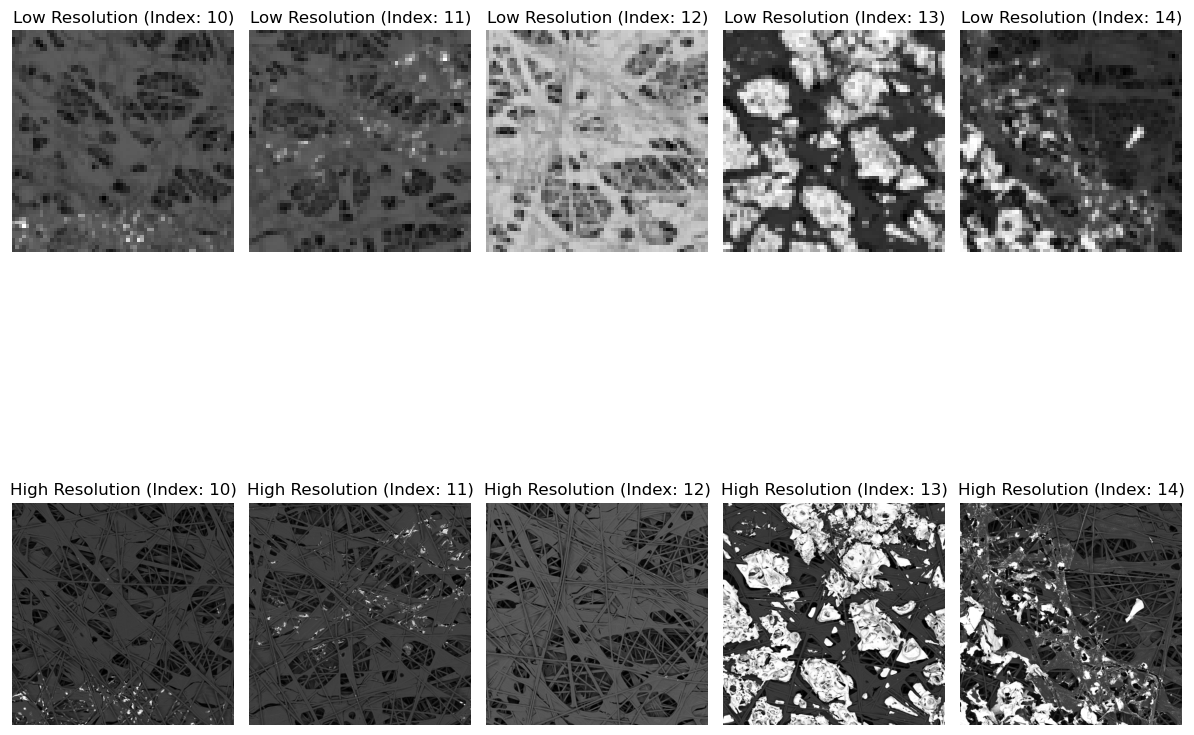

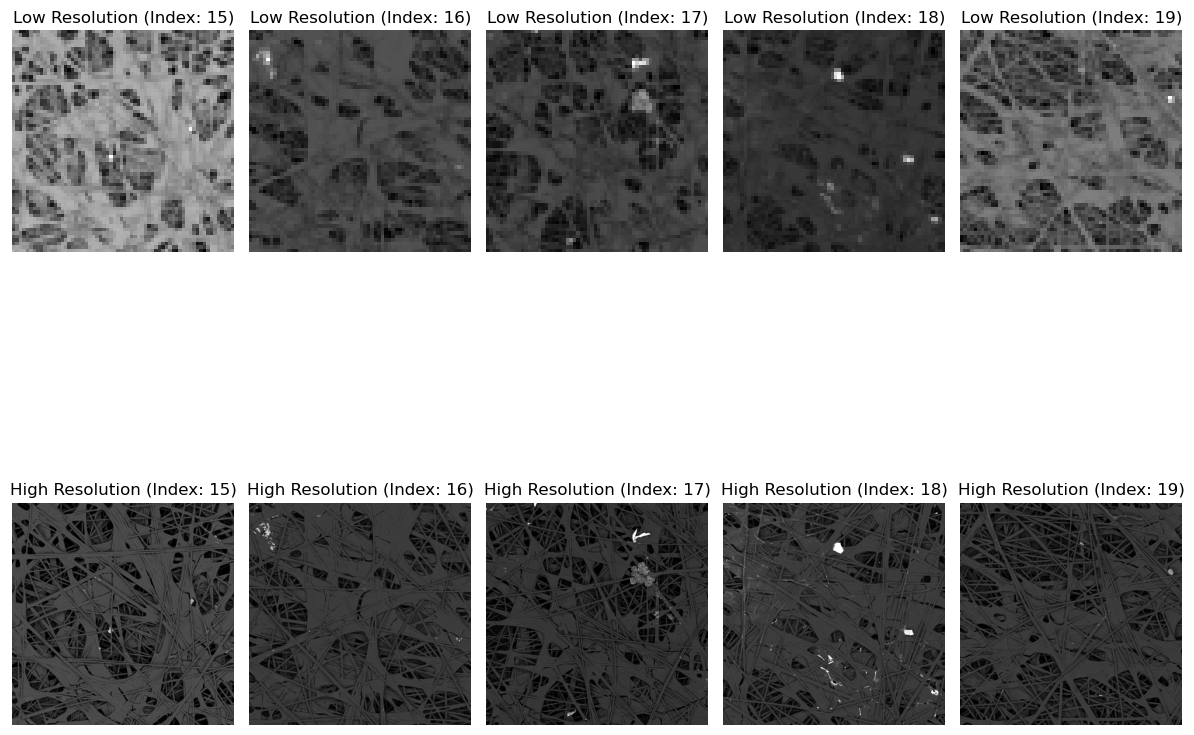

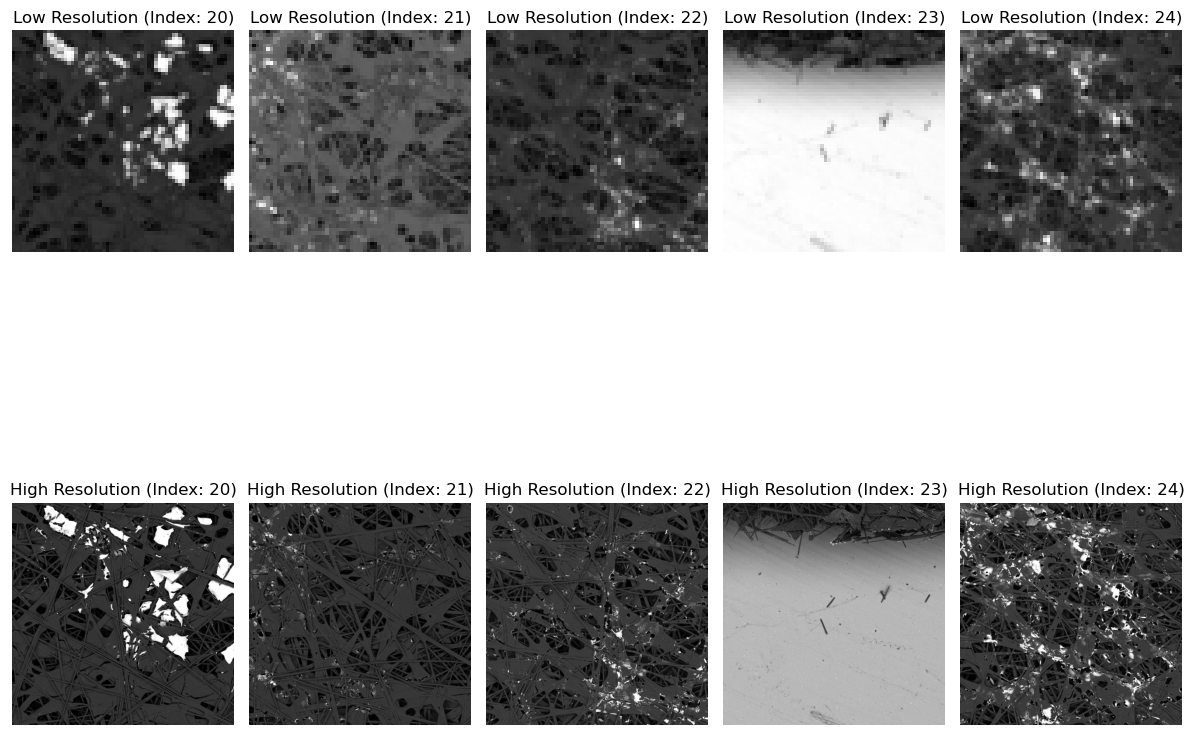

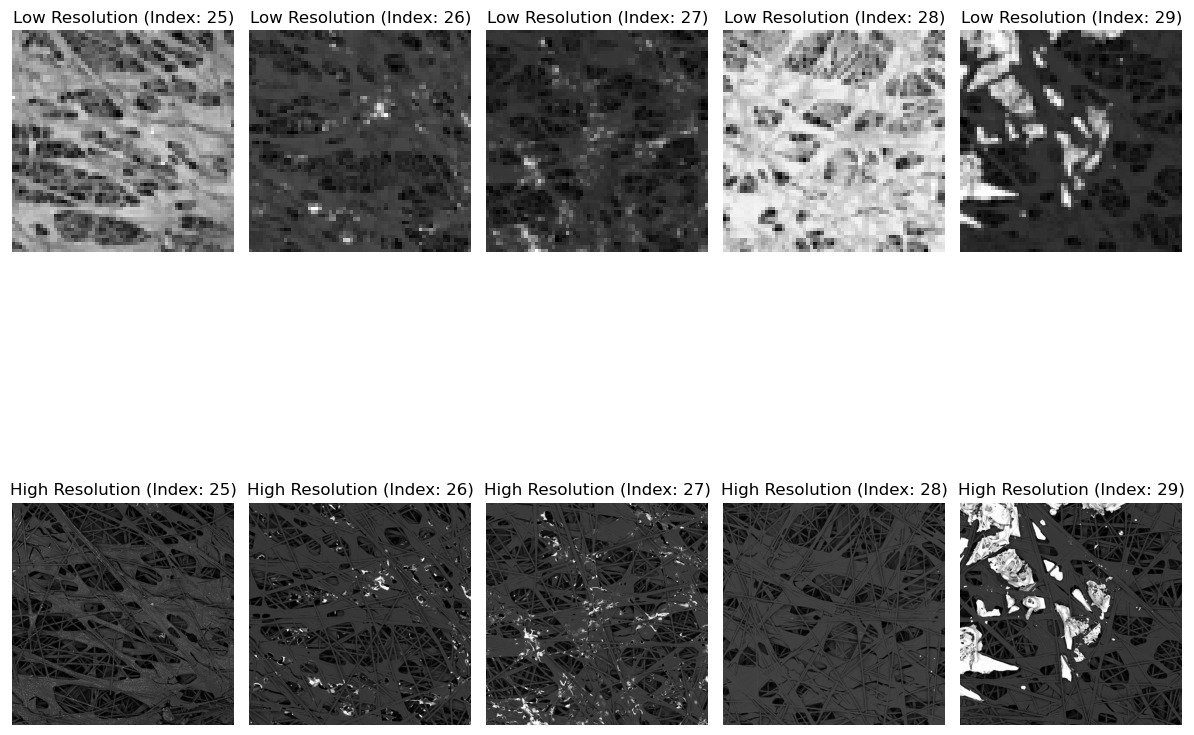

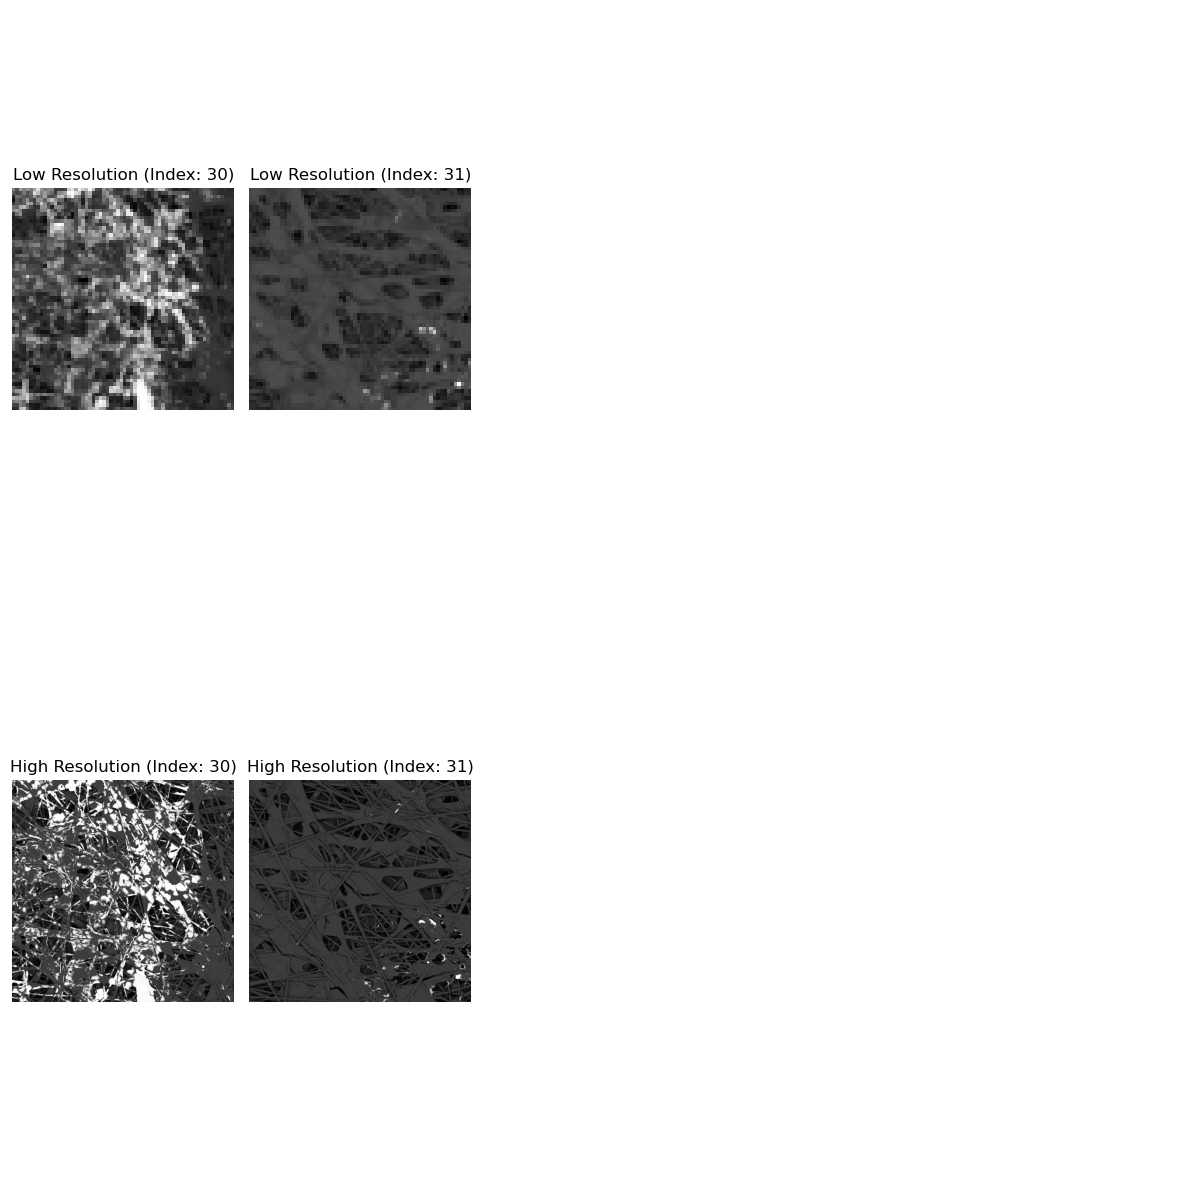

In [6]:
batch_size = lr_batch.shape[0]
pairs_per_row = 5
rows = (batch_size + pairs_per_row - 1) // pairs_per_row

L.seed_everything(42)

for row in range(rows):
    fig, axs = plt.subplots(2, pairs_per_row, figsize=(12, 12))
    for col in range(pairs_per_row):
        idx = row * pairs_per_row + col
        if idx >= batch_size:
            axs[0, col].axis("off")
            axs[1, col].axis("off")
            continue

        lr_img = lr_batch[idx].squeeze().numpy()
        hr_img = hr_batch[idx].squeeze().numpy()

        axs[0, col].imshow(lr_img, cmap='gray')
        axs[0, col].set_title(f"Low Resolution (Index: {idx})")
        axs[0, col].axis("off")

        axs[1, col].imshow(hr_img, cmap='gray')
        axs[1, col].set_title(f"High Resolution (Index: {idx})")
        axs[1, col].axis("off")

    plt.tight_layout()
    plt.show()

# DRAFT

In [11]:
class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * self.scale

In [12]:
test = nn.Conv2d(1,3,kernel_size=3,padding=1)

In [13]:
x = torch.rand(32,1,64,64)

y = test(x)

x.shape,y.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32, 3, 64, 64]))

In [19]:
x = torch.arange(16).reshape(2, 8)
x

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [20]:
x1, x2 = x.chunk(2,dim=1)
x1.shape,x2.shape

(torch.Size([2, 4]), torch.Size([2, 4]))

In [21]:
x1,x2

(tensor([[ 0,  1,  2,  3],
         [ 8,  9, 10, 11]]),
 tensor([[ 4,  5,  6,  7],
         [12, 13, 14, 15]]))